In [1]:
# imports for using the notebook

import pandas as pd
import sys
sys.path.append('../')
from embedding_functions_hugo.embedding_functions import *
from sklearn.preprocessing import StandardScaler
import numpy as np
from numpy import genfromtxt
import nltk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, FeatureAgglomeration
from sklearn.decomposition import PCA
import seaborn as sns
import networkx as nx

from tqdm import tqdm 


def shorten_and_clean_dataset (comment_csv, comment_column : str, desired_comment_length : int):
    dataframe = pd.read_csv(comment_csv)
    dataframe['cleaned_text'] = prep_pipeline(dataframe, comment_column)
    dataframe['short'] = shorten_sens(dataframe['cleaned_text'], desired_comment_length)
    return dataframe

In [2]:
df_politics = pd.read_csv('../data/28feb/scrapes/politics.csv')

In [3]:
def do_post_titles(df):

    texts, authors, post_ids = [], [], []
    title_author_set = set(zip(df['post_title'], df['post_author'], df['post_id'])) 

    for text, author, post_id in  title_author_set:
        texts.append(text)
        authors.append(author)
        post_ids.append(post_id)
    
    title_embeddings = embed_comments(texts)
    return pd.DataFrame(data=[post_ids, authors, texts, title_embeddings]).T.rename(columns={0 : 'post_id', 1: 'post_author', 2: 'post_title', 3: 'embeddings'})
politics_data = do_post_titles(df_politics)

2023-03-06 15:40:26.610631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


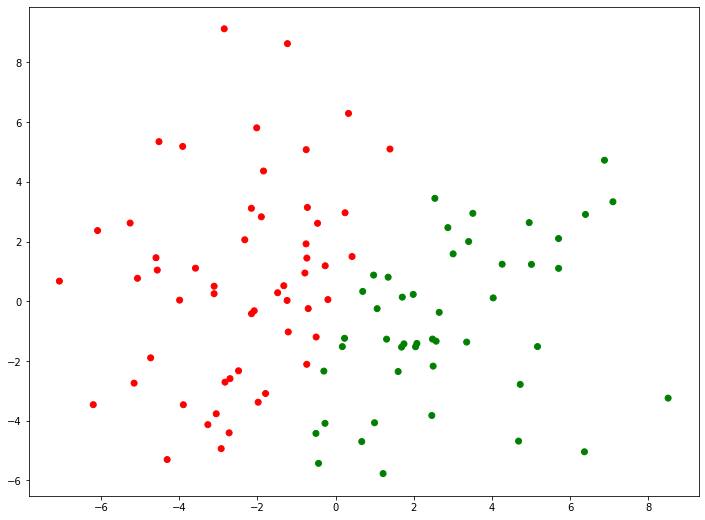

In [4]:
plt.figure(1, figsize=(12,9))

reduce_dims_and_kmeans(dict(politics_data['embeddings']), 2)

In [5]:
reduce_to_one_dimension_kmeans(dict(politics_data['embeddings']))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1], dtype=int32),
 array([[-0.7338243 ],
        [ 0.97330423],
        [-3.26497811],
        [ 0.23097905],
        [ 4.26075663],
        [ 0.99618232],
        [ 0.24334175],
        [-4.51457801],
        [ 2.87179876],
        [-4.72802538],
        [-6

In [6]:
politics_data['one_dim'] = reduce_to_one_dimension_kmeans(dict(politics_data['embeddings']))[-1]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

from bs4 import BeautifulSoup 
import re

from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline
from happytransformer import HappyTextClassification


In [8]:
model = HappyTextClassification(model_type='DISTILBERT', model_name='distilbert-base-uncased-finetuned-sst-2-english', num_labels=2)

03/06/2023 15:40:40 - INFO - happytransformer.happy_transformer -   Using model: cpu


In [9]:
graph_1 = nx.Graph()
# graph_1.add_nodes_from(list(politics_data['post_author']))
# nx.set_node_attributes(graph_1, politics_data['one_dim'], 'score')

In [10]:
politics_data['one_dim']

0    -0.734102
1     0.973568
2    -3.264441
3     0.230825
4     4.260843
        ...   
95   -0.298444
96    0.695007
97    3.402530
98    2.571880
99    2.494744
Name: one_dim, Length: 100, dtype: float64

In [11]:
politics_data

,post_id,post_author,post_title,embeddings,one_dim
0,11dqm6c,Hot-Bint,Rupert Murdoch gave Jared Kushner 'confidentia...,"[-0.19192341, 0.80211586, -0.16259597, 0.42272...",-0.734102
1,11f4pxp,bildo72,"To lower military suicides, Pentagon panel adv...","[0.23700176, 0.5473592, 0.6111684, 0.40033782,...",0.973568
2,10wuxdo,mdj1359,"Dark Brandon shows up at State of the Union, m...","[-0.08714572, 0.9927409, -0.07985403, 0.439079...",-3.264441
3,10yy47m,CrackHeadRodeo,Republican Rep. Anna Paulina Luna claimed she ...,"[0.078912154, 0.27851197, -1.0702236, 0.009658...",0.230825
4,11i1w2v,boregon,Florida courts could take 'emergency' custody ...,"[-0.1093924, -0.47195092, 0.5826997, 0.0496520...",4.260843
...,...,...,...,...,...
95,118a6w8,TalcMine,Biden EPA to take over cleanup of toxic Ohio d...,"[-0.17619674, 0.69390506, 0.35494787, 0.145533...",-0.298444
96,11h0v4n,Pemulis,Rupert Murdoch could face FEC fines if he tipp...,"[-0.057751726, 0.6316826, 0.18160732, 0.196764...",0.695007
97,10wghis,vpuetf,Florida is officially a laboratory for fascism...,"[-0.19462377, -0.17132975, 0.3380608, 0.399728...",3.402530
98,116a70w,hopopo,Bernie Sanders: ‘Oligarchs run Russia. But gue...,"[-0.1697526, 0.4053155, -0.12408501, 0.4396499...",2.571880


In [12]:
author_df = df_politics.query('comment_author in post_author').copy()
clean_text = prep_pipeline(author_df, 'comment_text')
author_df['short_text'] = shorten_sens(clean_text, 50)

lowering done!
Contractions removed!
urls away!
htmls too!
asciis outta here!
special  characs done
puncts done
long one...


In [13]:
embed_pairs = {}
for text, author in zip(author_df['post_title'], author_df['post_author']):
    if author not in embed_pairs.keys():
        embed_pairs[author] = text
    else:
        embed_pairs[author] += ' '+text

In [14]:
yas  = dict(zip(embed_pairs.keys(),embed_comments(list(embed_pairs.values()))))
yas =reduce_to_one_dimension_kmeans(yas)[-1]

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
yas

array([[-4.83723486],
       [-2.15131746],
       [-3.74694958],
       [-3.81239968],
       [ 2.13432135],
       [ 4.53322595],
       [-1.96883869],
       [-3.92539782],
       [-2.77570035],
       [-1.31256424],
       [ 5.29682305],
       [-1.82858446],
       [-0.47601628],
       [ 1.27235565],
       [-4.01146533],
       [ 0.67839138],
       [ 3.29645277],
       [-4.0251622 ],
       [-3.95259351],
       [ 0.75190188],
       [-1.48510865],
       [-2.48253709],
       [10.40476778],
       [-4.87989041],
       [ 2.33302161],
       [-1.28399745],
       [-0.55653052],
       [-4.01094063],
       [ 3.09003721],
       [ 4.29006846],
       [11.3523701 ],
       [ 1.71345724],
       [-1.24094376],
       [ 3.10589021],
       [ 3.02814482],
       [ 5.95451694],
       [-1.83331452],
       [-5.2682597 ],
       [-1.36999922]])

In [16]:
for i, j in zip(embed_pairs.keys(),yas):
    graph_1.add_node(i, polarity = int(j))

In [17]:
pairings = list(zip(author_df['comment_author'], author_df['post_author']))

In [18]:
polarities = []
for comment in author_df['short_text']:
    polarities.append(model.classify_text(comment).label)

In [19]:
for pair, polarity in zip(pairings, polarities):
    graph_1.add_edge(u_of_edge=pair[0], v_of_edge=pair[1], attr=polarity)

In [20]:
graph_1.edges

EdgeView([('Picture-unrelated', 'Picture-unrelated'), ('Picture-unrelated', 'LudovicoSpecs'), ('newnemo', 'newnemo'), ('newnemo', 'hopopo'), ('newnemo', 'slaysia'), ('newnemo', 'GDPisnotsustainable'), ('newnemo', 'LudovicoSpecs'), ('newnemo', 'e-r_bridge'), ('newnemo', 'AceCombat9519'), ('theindependentonline', 'theindependentonline'), ('Ozymandias_a', 'Ozymandias_a'), ('LuvKrahft', 'hopopo'), ('LuvKrahft', 'boregon'), ('LuvKrahft', 'modooff'), ('LuvKrahft', 'CrackHeadRodeo'), ('LuvKrahft', 'Darzanak'), ('LuvKrahft', 'MortWellian'), ('semaphore-1842', 'semaphore-1842'), ('HauntingJackfruit', 'LieutJimDangle'), ('bildo72', 'bildo72'), ('bildo72', 'dude_x'), ('joyfullypresent', 'joyfullypresent'), ('CBSnews', 'CBSnews'), ('Sharp_Literature_739', 'Sharp_Literature_739'), ('Sharp_Literature_739', 'Teanaway99'), ('myTchondria', 'myTchondria'), ('FFFFFM', 'Hot-Bint'), ('JackFourj4', 'JackFourj4'), ('ladyem8', 'Scarlettail'), ('Beckles28nz', 'Beckles28nz'), ('Beckles28nz', 'AceCombat9519'), (

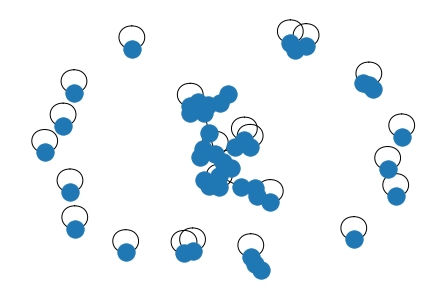

In [21]:
nx.draw(graph_1)

In [22]:
len(graph_1)

46

In [23]:
nx.write_gexf(graph_1, '../data/28feb/graphs/politics_network.gexf')